In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

[ WARN:0@3.489] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


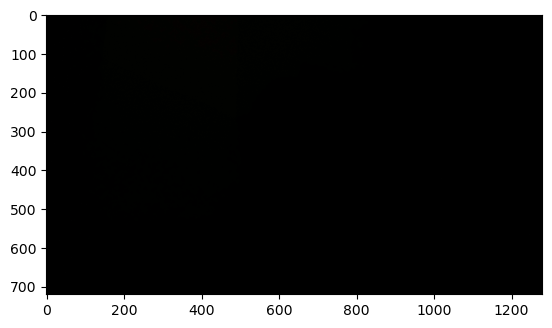

In [3]:
def capture_image():
    # Open the default camera (index 0)
    cap = cv2.VideoCapture(0)

    # Check if the camera is opened successfully
    if not cap.isOpened():
        print("Failed to open the camera")
        return None

    # Read the image from the camera
    ret, frame = cap.read()

    # Release the camera
    cap.release()

    # Check if the image was read successfully
    if not ret:
        print("Failed to capture the image")
        return None

    # Convert the image to RGB format
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    return image

# Capture an image from the webcam
image = capture_image()

np.save('hand_image.npy', image)
plt.imshow(image)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


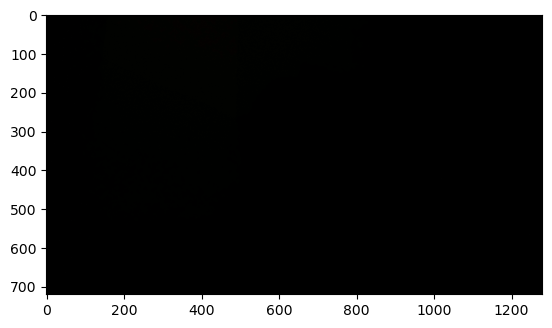

In [4]:
def detect_hand_landmarks(image):
    mp_drawing = mp.solutions.drawing_utils
    mp_hands = mp.solutions.hands

    # Load the MediaPipe Hands model
    with mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5) as hands:
        # Convert the image to RGB format
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image to detect hand landmarks
        results = hands.process(image_rgb)

        # Check if any hands were detected
        if results.multi_hand_landmarks:
            # Iterate through each detected hand
            for hand_landmarks in results.multi_hand_landmarks:
                # Draw the landmarks on the image
                mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

                # Extract the landmarks for each finger
                for finger_id in range(5):
                    finger_landmarks = hand_landmarks.landmark[mp_hands.HandLandmark.WRIST + (finger_id * 4):mp_hands.HandLandmark.WRIST + (finger_id * 4) + 4]

    # Return the image with landmarks drawn
    return image, results

# Load an image or capture from a camera

# Detect hand landmarks and display the result
image, results = detect_hand_landmarks(np.load('hand_image.npy'))
plt.imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
def capture_images_interval(interval, total_images, sign_name):
    images = []
    # Open the default camera (index 0)
    cap = cv2.VideoCapture(0)

    # Check if the camera is opened successfully
    if not cap.isOpened():
        print("Failed to open the camera")
        return

    image_count = 0

    while image_count < total_images:
        # Read the current frame from the camera
        ret, frame = cap.read()



        # Display the current frame
        cv2.putText(frame, f"{sign_name} taken: {image_count}/{total_images}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow("Camera Footage", frame)



        # Check if the image should be captured
        if time.time() % interval < 0.1:
            ret, frame = cap.read()

            # Increment the image count
            image_count += 1

            # Display the captured image
            cv2.imshow("Captured Image", frame)
            cv2.waitKey(1000)  # Display the captured image for 1 second
            images.append(frame)

        # Check for 'q' key press to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the camera and close all windows
    cap.release()
    cv2.destroyAllWindows()
    return images

def save_image(path, image):
    np.save(path, image)

signs = ['open-hand', 'rock-on', 'peace', 'surf']

"""
for sign in signs:
    nb_images = 15
    interval = 4

    images = capture_images_interval(interval, nb_images, sign)

    for i in range(int(nb_images * 0.7)):
        cv2.imwrite(os.path.join('images', 'train', sign,  str(i) + '.jpg'), images[i])

    for i in range(int(nb_images * 0.7), len(images)):
        cv2.imwrite(os.path.join('images', 'test', sign , str(i) + '.jpg'), images[i])
"""


"\nfor sign in signs:\n    nb_images = 15\n    interval = 4\n\n    images = capture_images_interval(interval, nb_images, sign)\n\n    for i in range(int(nb_images * 0.7)):\n        cv2.imwrite(os.path.join('images', 'train', sign,  str(i) + '.jpg'), images[i])\n\n    for i in range(int(nb_images * 0.7), len(images)):\n        cv2.imwrite(os.path.join('images', 'test', sign , str(i) + '.jpg'), images[i])\n"

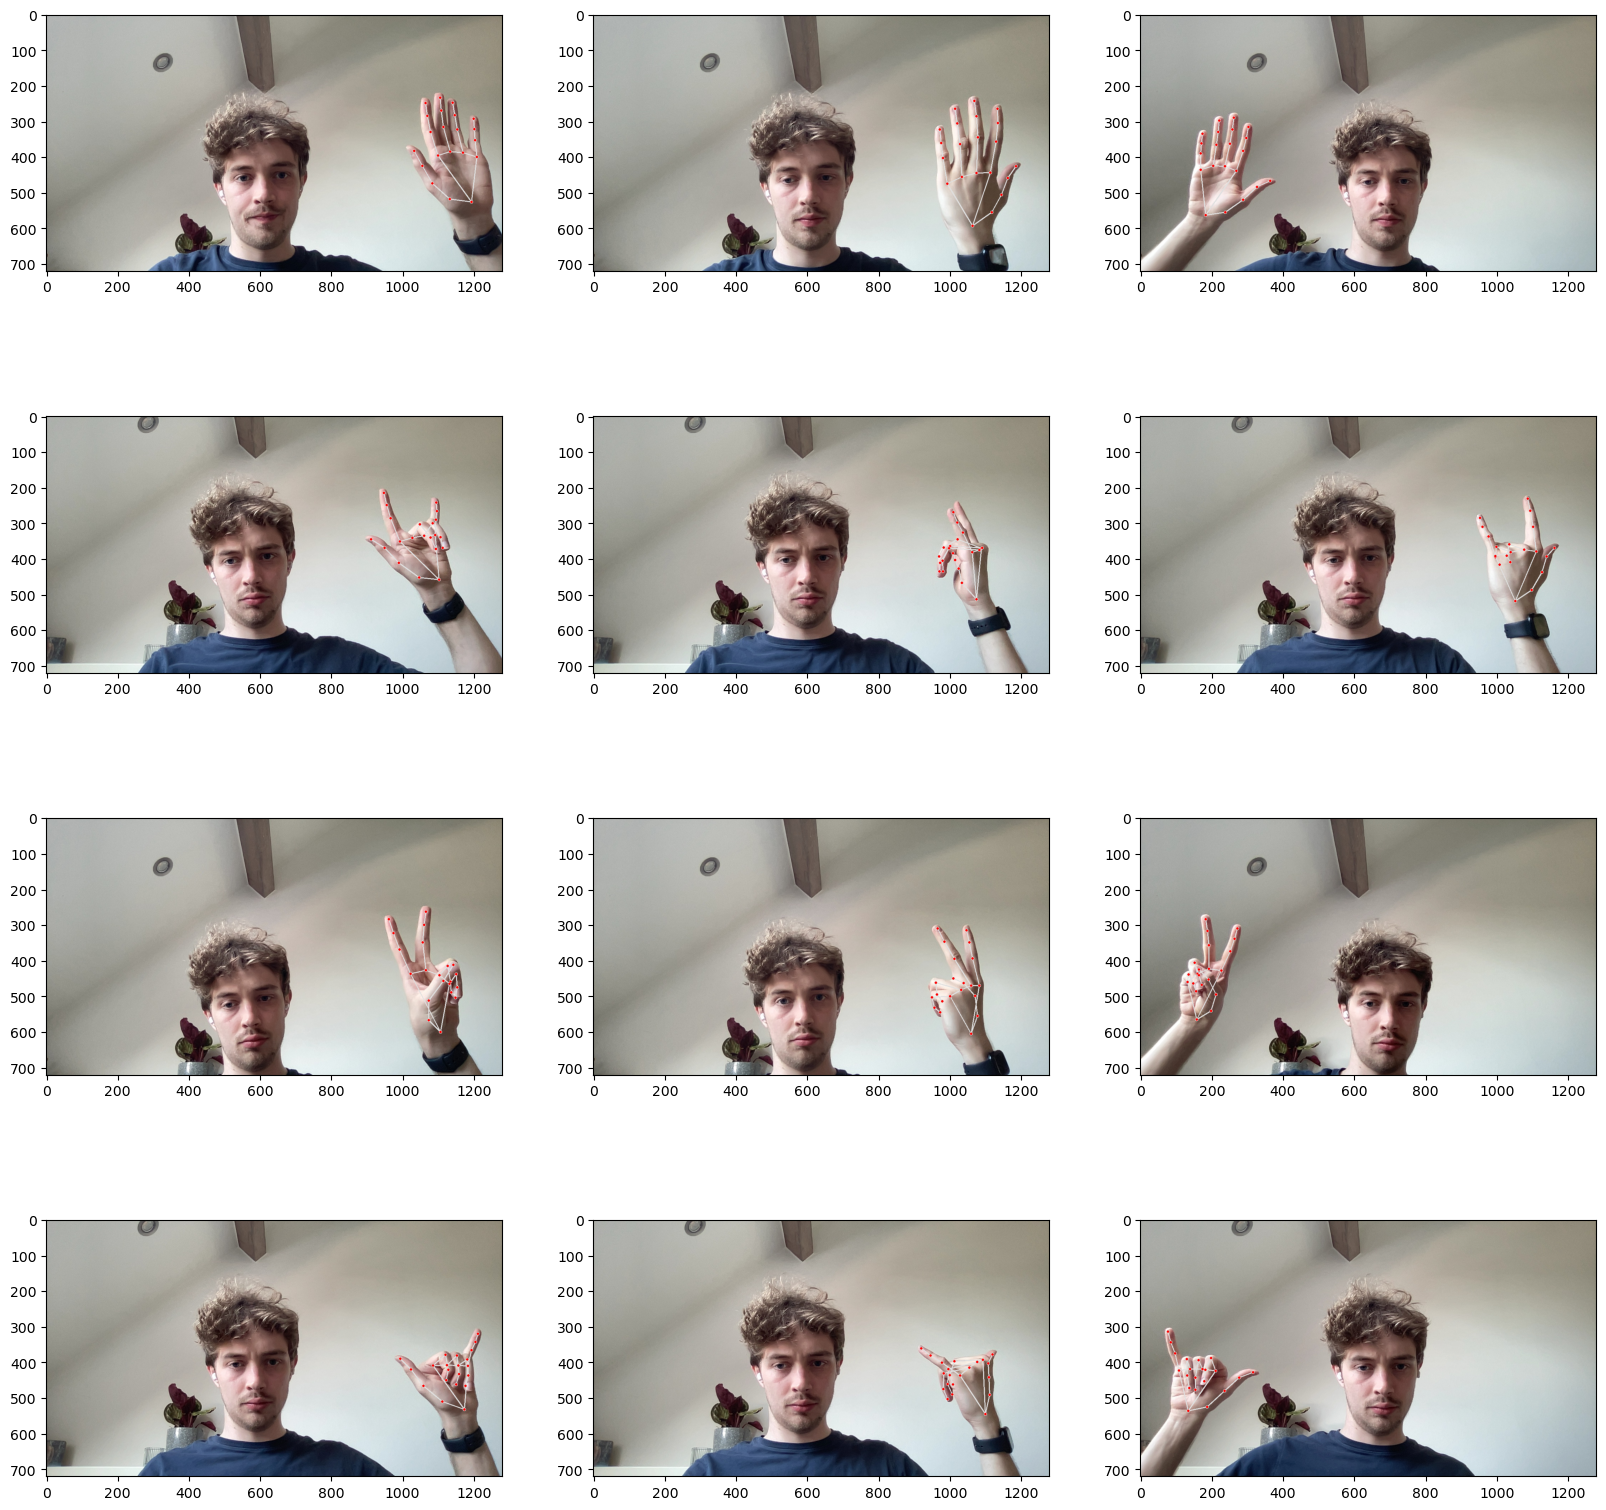

In [6]:
def read_image(path):
    return cv2.imread(path)

fig, axes = plt.subplots(len(signs),3, figsize=(20,20))

for k in range(len(signs)):
    for i in range(3):
        image = read_image(os.path.join('images', 'train', signs[k],str(i) + '.jpg'))
        image, results = detect_hand_landmarks(image)
        axes[k][i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

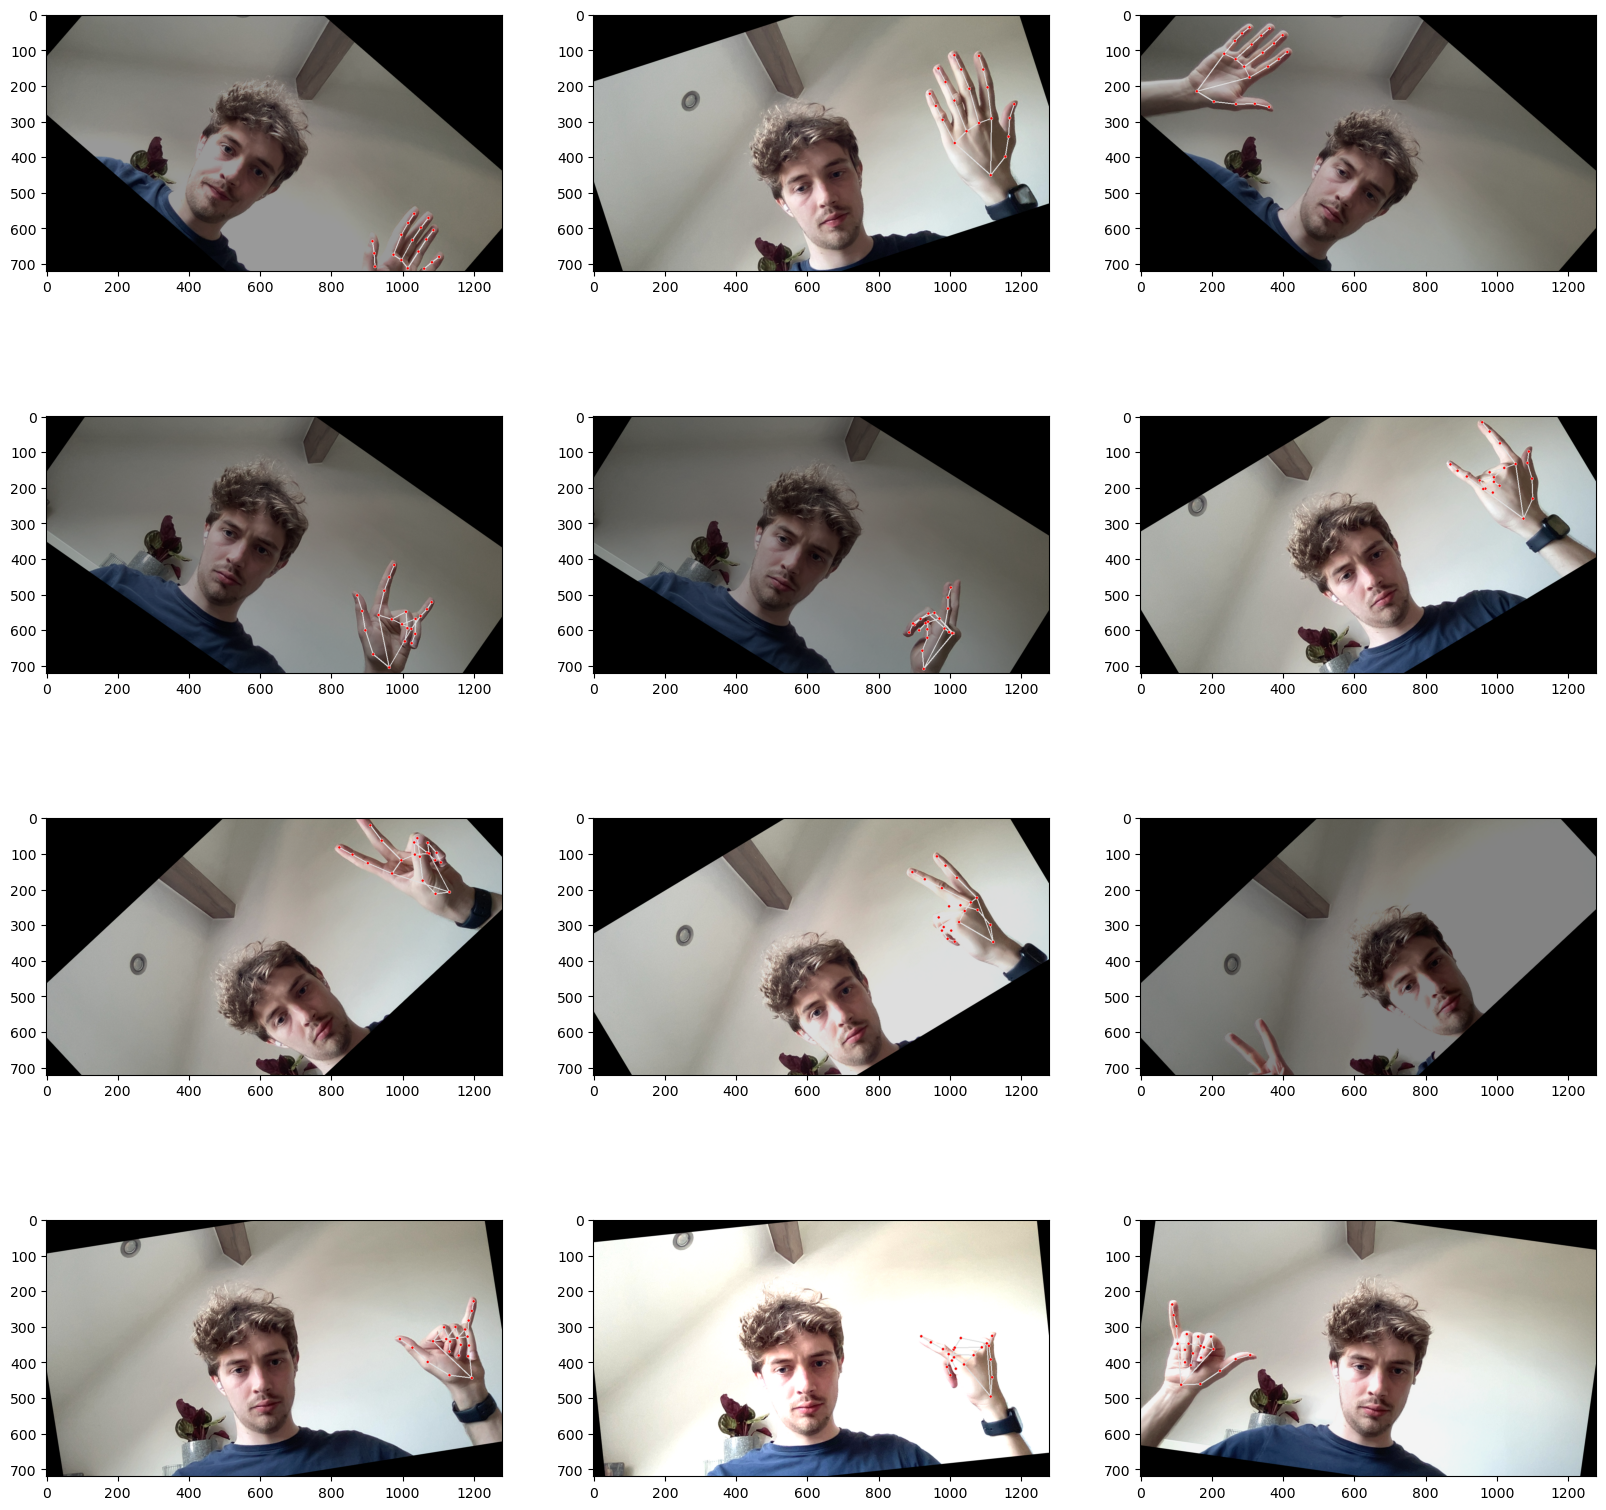

In [7]:
def random_augment(image):
    brightness_factor = np.random.uniform(0.5, 1.5)
    contrast_factor = np.random.uniform(0.5, 1.5)
    angle = np.random.randint(-45, 45)
    return augment_image(image, brightness_factor, contrast_factor, angle)

def augment_image(image, brightness_factor, contrast_factor, angle):
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)

    augmented_image = cv2.convertScaleAbs(image, alpha=brightness_factor)
    augmented_image = cv2.convertScaleAbs(augmented_image, alpha=contrast_factor, beta=0)
    augmented_image = cv2.warpAffine(augmented_image, M, (cols, rows))

    return augmented_image


fig, axes = plt.subplots(len(signs),3, figsize=(20,20))

for k in range(len(signs)):
    for i in range(3):
        image = read_image(os.path.join('images', 'train', signs[k], str(i) + '.jpg'))

        image, results = detect_hand_landmarks(random_augment(image))

        axes[k][i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [8]:
def preprocess_landmarks(landmarks):
    return np.array([[point.x, point.y, point.z]for point in landmarks.multi_hand_landmarks[0].landmark]).flatten()

In [9]:
from random import randint
import pandas as pd
def generate_data(path, signs, amount=5):
    data = []
    for i in range(len(signs)):
        sign_data = []
        for _ in range(amount):
            

            image_paths = os.listdir(os.path.join(path, signs[i]))

            image_path = os.path.join(path, signs[i], image_paths[randint(0, len(image_paths) - 1)])


            try:
                _, landmarks = detect_hand_landmarks(random_augment(read_image(image_path)))
                landmarks = preprocess_landmarks(landmarks)
            except TypeError:
                landmarks = np.zeros(63)

            sign_data.append(landmarks)


        data.append(pd.DataFrame({'X' : sign_data, 'y': [i for _ in range(len(sign_data))]}))

    return pd.concat(data)

train_data = generate_data(os.path.join('images', 'train'), signs, amount=200)

In [10]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

models = [RandomForestClassifier(), GradientBoostingClassifier(), SVC(), KNeighborsClassifier(), LogisticRegression()]

for model in models:
    model = model.fit(np.array([entry for entry in train_data['X']]), train_data['y'])

/Users/stijn/miniconda3/envs/CV/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
test_data = generate_data(os.path.join('images', 'test'), signs, amount=50)

In [12]:
from sklearn.metrics import f1_score, accuracy_score

highest_score = 0
best_model = None
for model in models:
    print(model)
    preds = model.predict(np.array([entry for entry in test_data['X']]))
    print('Accuracy: ' + str(accuracy_score(test_data['y'].values, preds)))

    f1 = f1_score(test_data['y'].values, preds, average='micro')
    print('F1 scores: ' + str(f1))

    if f1 > highest_score:
        highest_score = f1
        best_model = model


RandomForestClassifier()
Accuracy: 0.625
F1 scores: 0.625
GradientBoostingClassifier()
Accuracy: 0.735
F1 scores: 0.735
SVC()
Accuracy: 0.73
F1 scores: 0.7299999999999999
KNeighborsClassifier()
Accuracy: 0.635
F1 scores: 0.635
LogisticRegression()
Accuracy: 0.815
F1 scores: 0.815


In [13]:
def capture_gestures_interval(interval, total_gestures, gesture_length_frames, sign_name, path):
    gestures = []
    # Open the default camera (index 0)
    cap = cv2.VideoCapture(0)

    # Check if the camera is opened successfully
    if not cap.isOpened():
        print("Failed to open the camera")
        return
    
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    

    gesture_count = 0

    while gesture_count < total_gestures:
        # Read the current frame from the camera
        ret, frame = cap.read()



        # Display the current frame
        cv2.putText(frame, f"{sign_name} taken: {gesture_count}/{total_gestures}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow("Camera Footage", frame)



        # Check if the image should be captured
        if time.time() % interval < 0.1:
            out = cv2.VideoWriter(os.path.join(path, sign_name, str(gesture_count) + '.mp4'), fourcc, 25, (frame_width,frame_height))
            for _ in range(gesture_length_frames):
                _, frame = cap.read()
                out.write(frame)

                cv2.putText(frame, "RECORDING", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                cv2.imshow("Camera Footage", frame)
                
            out.release()
            gesture_count += 1

        # Check for 'q' key press to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the camera and close all windows
    cap.release()
    cv2.destroyAllWindows()
    return gestures

def save_image(path, image):
    np.save(path, image)

gesture_types = ['other', 'wave']

"""
for type in gesture_types:
    nb_gestures = 15
    interval = 5

    gestures = capture_gestures_interval(interval, int(nb_gestures * 0.6667), 50, type, os.path.join('gestures', 'train'))
    gestures = capture_gestures_interval(interval, int(nb_gestures * 0.3334), 50, type, os.path.join('gestures', 'test'))
"""


"\nfor type in gesture_types:\n    nb_gestures = 15\n    interval = 5\n\n    gestures = capture_gestures_interval(interval, int(nb_gestures * 0.6667), 50, type, os.path.join('gestures', 'train'))\n    gestures = capture_gestures_interval(interval, int(nb_gestures * 0.3334), 50, type, os.path.join('gestures', 'test'))\n"

[ WARN:0@62.775] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@62.775] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin0 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@62.776] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@62.776] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/s

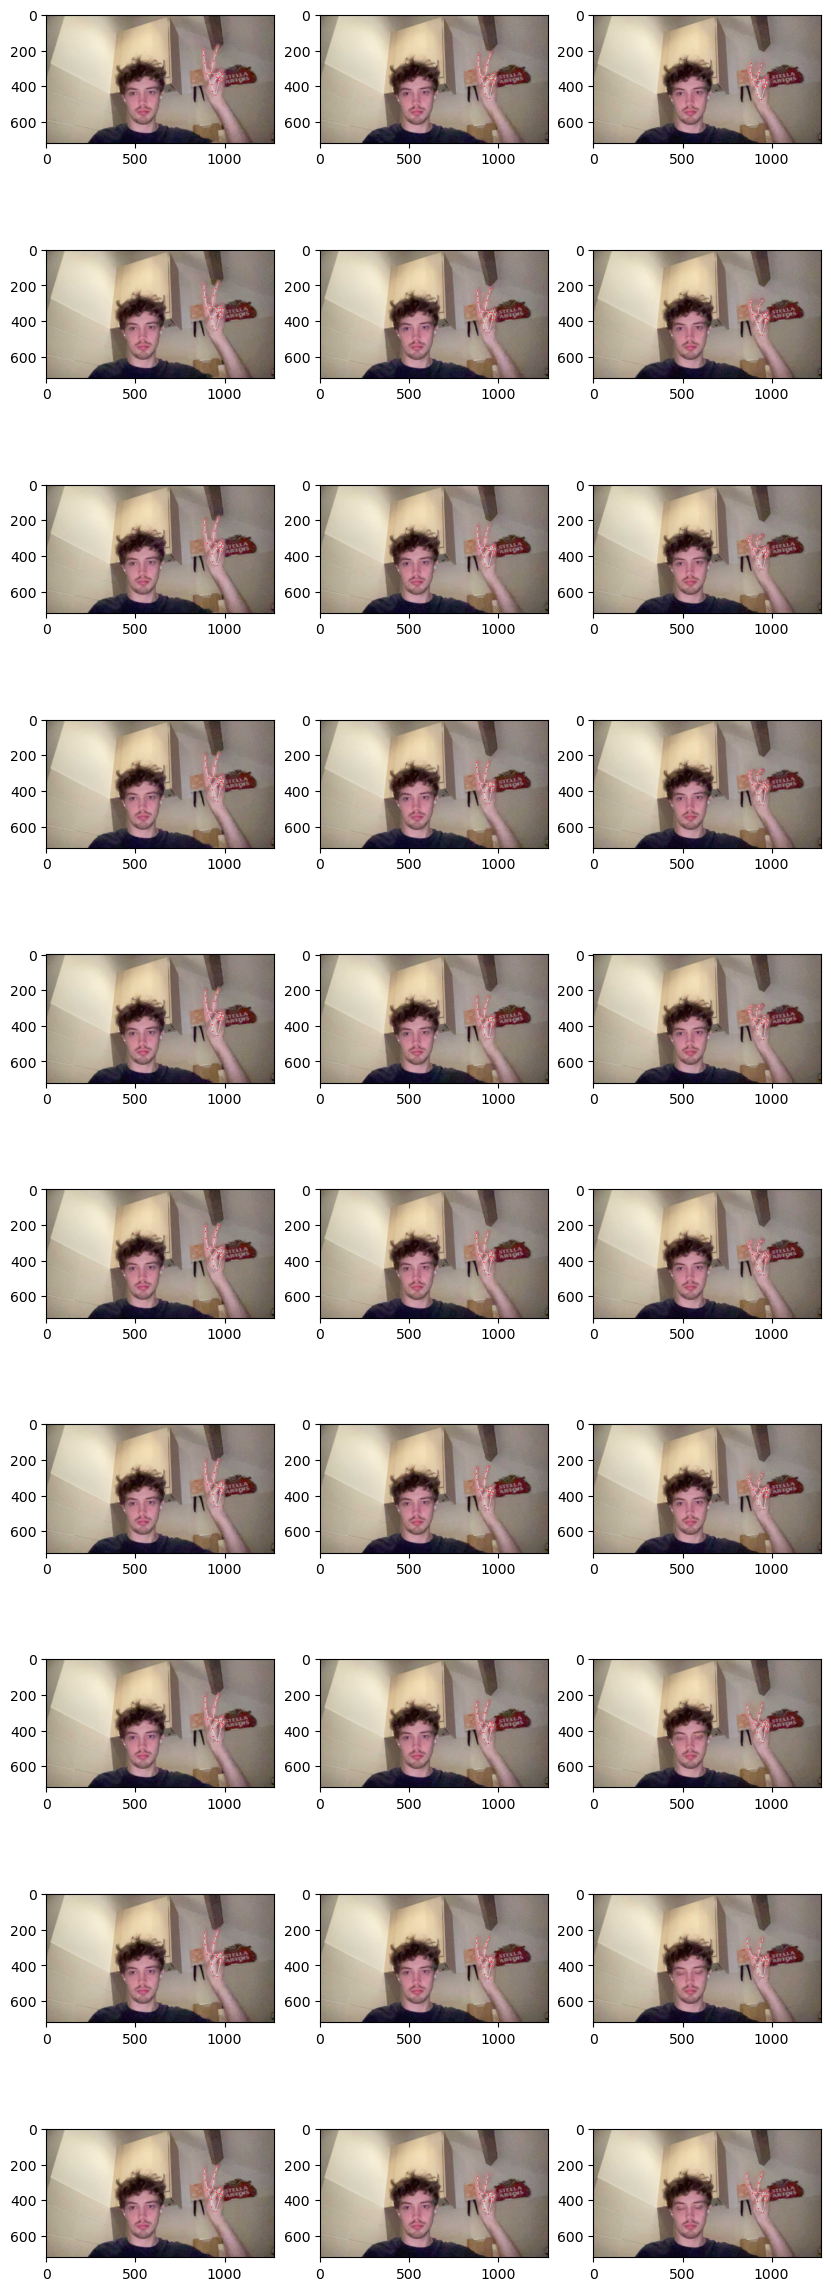

In [14]:
from matplotlib import animation
import matplotlib.cm as cm
def read_video(path):
    cap = cv2.VideoCapture(path)
    frames = []
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
        else:
            break
    return frames

def plot_first_30_frames(frames):
    fig, axes = plt.subplots(10,3, figsize=(10,30))

    for i in range(30):
        row = i % 10
        col = i // 10
        image, results = detect_hand_landmarks(frames[i])
        axes[row, col].imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))

plot_first_30_frames(read_video(os.path.join('gestures', 'train', 'other', '6.mp4')))

[ WARN:0@67.061] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@67.061] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin1 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@67.061] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@67.061] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/s

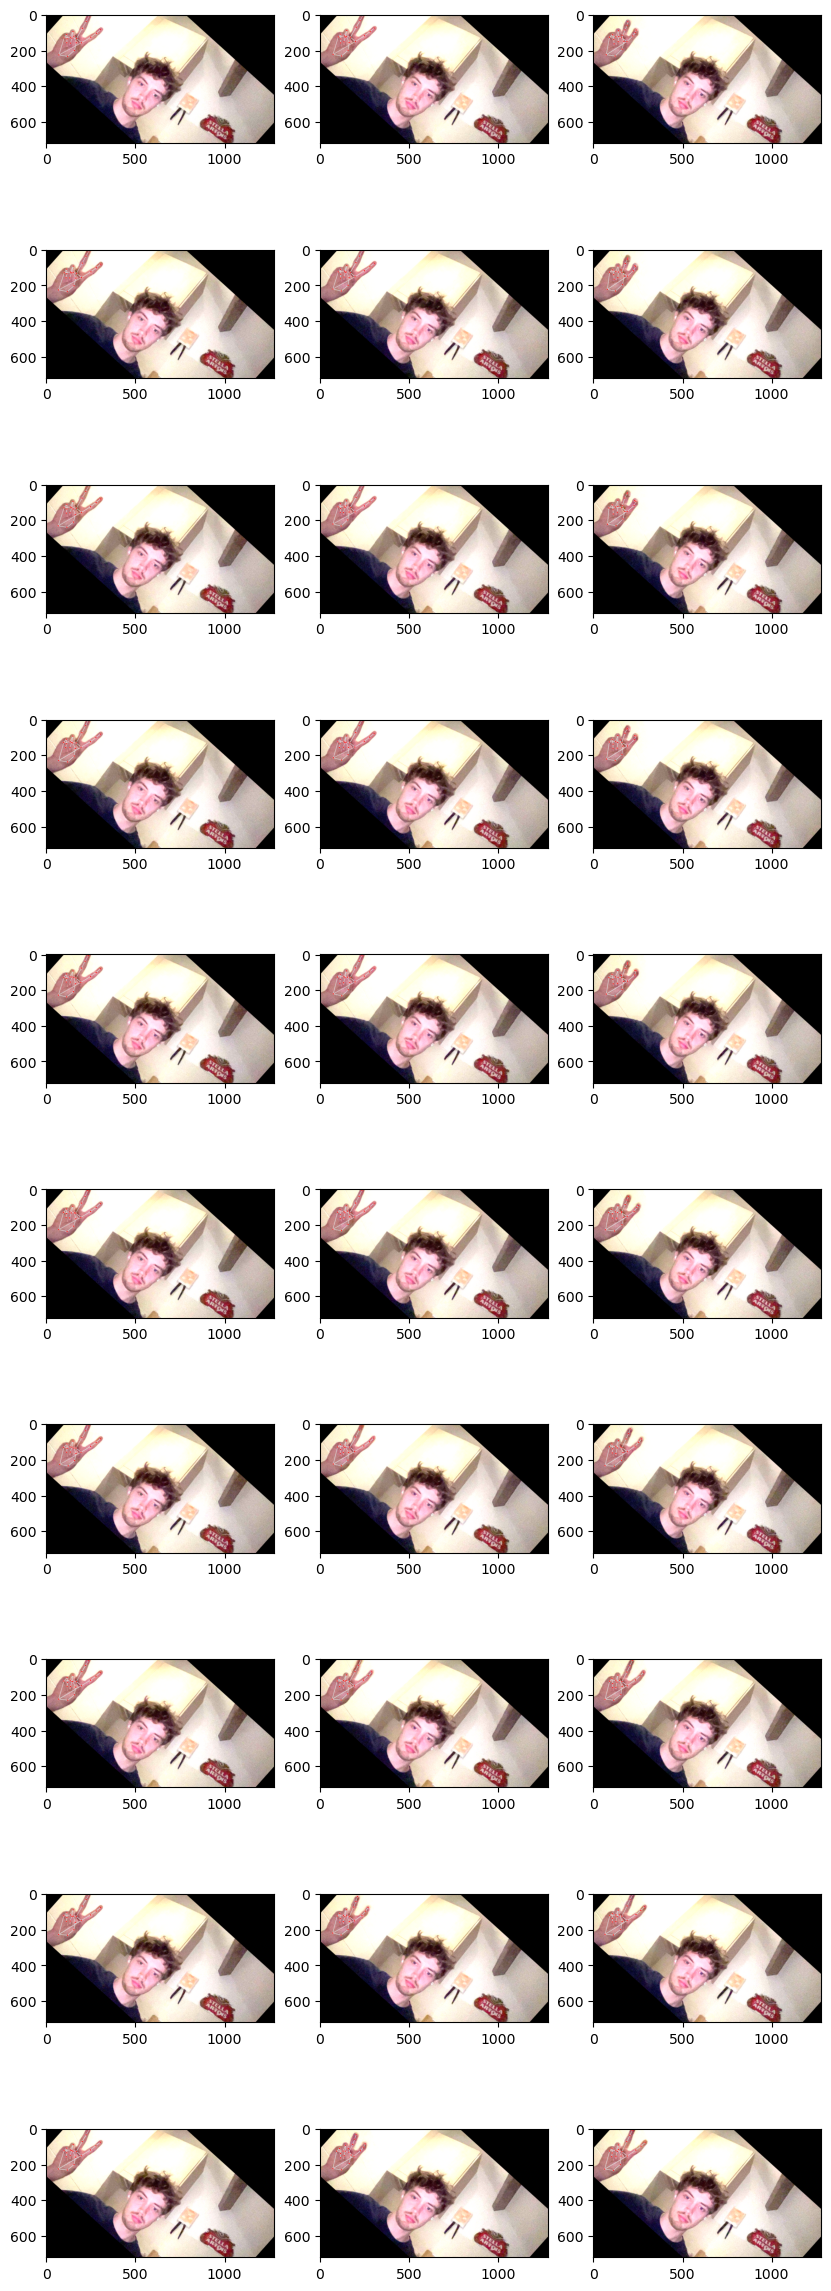

In [15]:
def random_augment_video(frames):
    brightness_factor = np.random.uniform(0.5, 1.5)
    #contrast_factor = np.random.uniform(0.5, 1.5)
    angle = np.random.randint(-45, 45)
    return np.array([augment_image(image, brightness_factor, 1, angle) for image in frames])


def augment_image(image, brightness_factor, contrast_factor, angle):
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)

    augmented_image = cv2.convertScaleAbs(image, alpha=brightness_factor)
    augmented_image = cv2.convertScaleAbs(augmented_image, alpha=contrast_factor, beta=0)
    augmented_image = cv2.warpAffine(augmented_image, M, (cols, rows))

    return augmented_image


plot_first_30_frames(random_augment_video(read_video(os.path.join('gestures', 'train', 'other', '4.mp4'))))

In [16]:
from random import choice
import pandas as pd
def generate_gesture_data(path, gestures, amount=5):
    data = []
    for i in range(len(gestures)):
        gesture_data = []
        gesture_videos = []
        gesture_paths = os.listdir(os.path.join(path, gestures[i]))
        for gesture_path in gesture_paths:
            gesture_videos.append(read_video(os.path.join(path, gestures[i], gesture_path)))
        for _ in range(amount):
            augmented_gesture = random_augment_video(choice(gesture_videos))
            gesture_landmarks = []
            for frame in augmented_gesture:
                try:
                    _, landmarks = detect_hand_landmarks(frame)
                    landmarks = preprocess_landmarks(landmarks)
                except TypeError:
                    landmarks = np.zeros(63)
                gesture_landmarks.append(landmarks)



            gesture_data.append(np.array(gesture_landmarks))


        data.append(pd.DataFrame({'X' : gesture_data, 'y': [i for _ in range(len(gesture_data))]}))

    return pd.concat(data)

train_data = generate_gesture_data(os.path.join('gestures', 'train'), gesture_types, amount=50)

[ WARN:0@71.532] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@71.532] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin2 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@71.532] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@71.532] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/s

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_lstm_model():
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(50,63)))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

# Create the LSTM model with multiple LSTM layers
lstm_model = create_lstm_model()

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 64)            32768     
                                                                 
 lstm_1 (LSTM)               (None, 50, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 187265 (731.50 KB)
Trainable params: 18726

In [18]:
lstm_model.fit(np.array([entry for entry in train_data['X']]), train_data['y'], epochs=100, batch_size=32)

Epoch 1/100
4/4 [==============================] - 2s 45ms/step - loss: 0.6905 - accuracy: 0.5700
Epoch 2/100
4/4 [==============================] - 0s 42ms/step - loss: 0.6814 - accuracy: 0.5900
Epoch 3/100
4/4 [==============================] - 0s 42ms/step - loss: 0.6674 - accuracy: 0.6300
Epoch 4/100
4/4 [==============================] - 0s 43ms/step - loss: 0.6534 - accuracy: 0.7000
Epoch 5/100
4/4 [==============================] - 0s 45ms/step - loss: 0.6499 - accuracy: 0.6400
Epoch 6/100
4/4 [==============================] - 0s 48ms/step - loss: 0.5977 - accuracy: 0.7000
Epoch 7/100
4/4 [==============================] - 0s 42ms/step - loss: 0.7693 - accuracy: 0.7600
Epoch 8/100
4/4 [==============================] - 0s 41ms/step - loss: 0.5722 - accuracy: 0.7100
Epoch 9/100
4/4 [==============================] - 0s 48ms/step - loss: 0.6397 - accuracy: 0.7500
Epoch 10/100
4/4 [==============================] - 0s 44ms/step - loss: 0.6511 - accuracy: 0.6900
Epoch 11/100
4/4 [=

In [19]:
test_data = generate_gesture_data(os.path.join('gestures', 'test'), gesture_types, amount=20)

[ WARN:0@315.941] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@315.941] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin22 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@315.941] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@315.941] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/vide

In [20]:
loss, acc = lstm_model.evaluate(np.array([entry for entry in test_data['X']]), test_data['y'].values)
print('Test set loss: ' + str(loss))
print('Test set acc: ' + str(acc))

2/2 [==============================] - 0s 9ms/step - loss: 0.7167 - accuracy: 0.4750
Test set loss: 0.7166622281074524
Test set acc: 0.4749999940395355


In [21]:
def predict_realtime(model):
    # Open the default camera (index 0)
    cap = cv2.VideoCapture(0)
    buffer_size = 50
    frame_buffer = []

    # Check if the camera is opened successfully
    if not cap.isOpened():
        print("Failed to open the camera")
        return

    while True:
        # Read the current frame from the camera
        ret, frame = cap.read()

       
        frame, landmarks = detect_hand_landmarks(frame)

        

        if landmarks.multi_hand_landmarks:
            prep_landmarks = preprocess_landmarks(landmarks)
            prediction = best_model.predict_proba([prep_landmarks])
            text = signs[np.argmax(prediction)]
            cv2.putText(frame, "prediction: " + text,  (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        else:
            prep_landmarks = np.zeros(63)

        frame_buffer.append(prep_landmarks)
        if len(frame_buffer) > buffer_size:
            frame_buffer.pop(0)

        
        if len(frame_buffer) == buffer_size:
            input = np.array(frame_buffer)
            predict_gesture = lstm_model.predict_step(np.array([input])).numpy()[0][0]
            if predict_gesture > 0.5:
                cv2.putText(frame, "Opening hand",  (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

            else:
                cv2.putText(frame, "Moving 2 fingers",  (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        

        # Check if the frame was read successfully
        if not ret:
            print("Failed to capture the frame")
            break

        # Display the frame
        cv2.imshow("Camera", frame)

        # Check for 'q' key press to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the camera and close all windows
    cap.release()
    cv2.destroyAllWindows()

predict_realtime(model)

[ WARN:0@404.913] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


In [23]:
import pickle
with open('model.pkl', 'wb') as write_file:
    pickle.dump(best_model, write_file)